# Continual Learning Analysis - Dataset Agnostic

Compare baseline vs. PSP models on arbitrary datasets and task transforms.

Features:
- Works with any torchvision dataset (MNIST, CIFAR-10, FashionMNIST, etc.)
- Supports multiple task transforms (Permutation, Rotation, Class-Incremental)
- Trains both baseline and context-aware models
- Visualizes accuracy curves and hidden representations via PCA


## Setup: Path Configuration

In [14]:
import os
import sys

repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(repo_root, "src")

if src_path not in sys.path:
    sys.path.insert(0, src_path)

print("Added to sys.path:", src_path)

Added to sys.path: /home/lleisner/projects/hands-on-neuroai/src


## Import Required Libraries

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from hands_on_neuroai.dataset_creation.datasets import (
    DatasetConfig, get_image_shape, get_num_classes,
    build_task_datasets, build_dataloaders,
    PermutePixels, Rotate, ComposeTaskTransforms
)
from hands_on_neuroai.training.continual_learning import (
    train_model_on_continual_learning_tasks
)
from hands_on_neuroai.training.metrics import collect_hidden_activations
from hands_on_neuroai.models.factory import build_model_for_continual_learning

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Configuration: Dataset, Tasks, and Model Parameters

Customize these settings to experiment with different datasets, task transforms, and models.

In [36]:
# ============ Dataset & Data Configuration ============
dataset_name = "fashion_mnist"  # Options: "mnist", "cifar10", "cifar100", "fashion_mnist"
data_root = os.path.join(repo_root, "data")

# ============ Task Configuration ============
num_tasks = 50
task_transform_type = "permutation"  # Options: "permutation", "rotation", "class_incremental"

# For permutation and rotation tasks
steps_per_task = 200
batch_size = 128

# ============ Model Configuration ============
hidden_dim = 256
context_type = "binary"  # Options: "none", "binary", "complex", "rotation"

# ============ Training Configuration ============
eval_interval = steps_per_task // 5
learning_rate = 1e-3
base_seed = 0

print(f"Dataset: {dataset_name}")
print(f"Task Transform: {task_transform_type}")
print(f"Num Tasks: {num_tasks}")
print(f"Model Context: {context_type}")
print(f"Device: {device}")

Dataset: fashion_mnist
Task Transform: permutation
Num Tasks: 50
Model Context: binary
Device: cuda


## Step 1: Build Data Loaders

Create data loaders with the specified dataset and task transforms.

In [37]:
# Create dataset config
config = DatasetConfig(root=data_root, download=False)

# Create task transforms based on task_transform_type
if task_transform_type == "permutation":
    task_transforms = [
        PermutePixels(seed=base_seed + i) 
        for i in range(num_tasks)
    ]
elif task_transform_type == "rotation":
    # Rotation angles from 0 to 180 degrees spread across tasks
    angles = [int(180 * i / (num_tasks - 1)) for i in range(num_tasks)]
    task_transforms = [Rotate(degrees=angles[i]) for i in range(num_tasks)]
elif task_transform_type == "class_incremental":
    # For class-incremental, we use a special builder
    from hands_on_neuroai.data.datasets import build_class_incremental_tasks
    input_dim, _ = get_image_shape(dataset_name)
    output_dim = get_num_classes(dataset_name)
    classes_per_task = output_dim // num_tasks
    
    train_dsets, test_dsets = build_class_incremental_tasks(
        dataset_name=dataset_name,
        config=config,
        class_splits=[
            list(range(i * classes_per_task, (i + 1) * classes_per_task))
            for i in range(num_tasks)
        ]
    )
    train_loaders = build_dataloaders(train_dsets, config, batch_size=batch_size, shuffle=True)
    test_loaders = build_dataloaders(test_dsets, config, batch_size=batch_size, shuffle=False)
    task_transforms = None  # Not needed for class-incremental
else:
    raise ValueError(f"Unknown task_transform_type: {task_transform_type}")

# For permutation and rotation, build task datasets with transforms
if task_transforms is not None:
    train_dsets, test_dsets = build_task_datasets(
        dataset_name=dataset_name,
        config=config,
        task_transforms=task_transforms
    )
    train_loaders = build_dataloaders(train_dsets, config, batch_size=batch_size, shuffle=True)
    test_loaders = build_dataloaders(test_dsets, config, batch_size=batch_size, shuffle=False)

print(f"Train loaders: {len(train_loaders)}, Test loaders: {len(test_loaders)}")
print(f"Task transforms: {task_transform_type}")

Train loaders: 50, Test loaders: 50
Task transforms: permutation


## Step 2: Initialize Baseline and Context-Aware Models

In [38]:
# Get dataset-specific dimensions
x, y = get_image_shape(dataset_name)
input_dim = x * y
output_dim = get_num_classes(dataset_name)

print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

# Build baseline model (no task awareness)
baseline = build_model_for_continual_learning(
    context_type="none",
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_tasks=num_tasks,
    base_seed=base_seed,
    device=device,
)

# Build context-aware model (with specified context type)
context_model = build_model_for_continual_learning(
    context_type=context_type,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_tasks=num_tasks,
    base_seed=base_seed,
    device=device,
)

print(f"Baseline model created")
print(f"Context model ({context_type}) created")

Input dimension: 784, Output dimension: 10
Baseline model created
Context model (binary) created


## Step 3: Train Models on Sequential Tasks

This cell trains both models sequentially across all tasks, recording accuracy on task 0 throughout training.

In [39]:
print("Training baseline model...")
base_steps, base_acc = train_model_on_continual_learning_tasks(
    model=baseline,
    train_loaders=train_loaders,
    test_loaders=test_loaders,
    num_tasks=num_tasks,
    steps_per_task=steps_per_task,
    lr=learning_rate,
    eval_interval=eval_interval,
    device=device,
    verbose=1
)

print("\nTraining context-aware model...")
ctx_steps, ctx_acc = train_model_on_continual_learning_tasks(
    model=context_model,
    train_loaders=train_loaders,
    test_loaders=test_loaders,
    num_tasks=num_tasks,
    steps_per_task=steps_per_task,
    lr=learning_rate,
    eval_interval=eval_interval,
    device=device,
    verbose=1
)

print("\nTraining complete!")

Training baseline model...


Tasks:   0%|          | 0/50 [00:00<?, ?it/s]

Training completed.

Training context-aware model...


Tasks:   0%|          | 0/50 [00:00<?, ?it/s]

Training completed.

Training complete!


## Step 4: Visualize Task-Specific Accuracy

Compare how both models maintain accuracy on the first task as they learn new tasks.

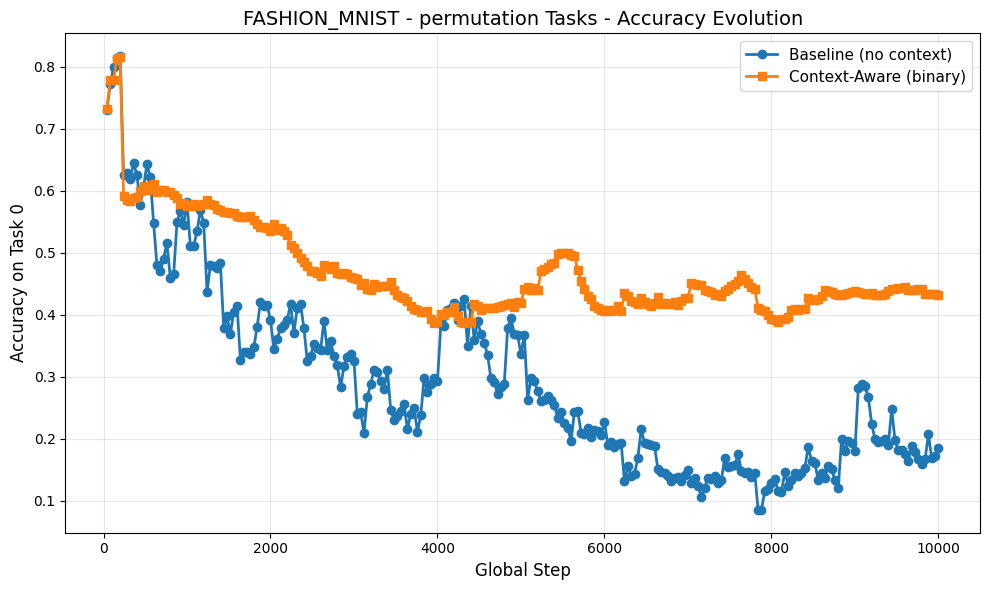

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(base_steps, base_acc, marker='o', label="Baseline (no context)", linewidth=2)
plt.plot(ctx_steps, ctx_acc, marker='s', label=f"Context-Aware ({context_type})", linewidth=2)
plt.xlabel("Global Step", fontsize=12)
plt.ylabel("Accuracy on Task 0", fontsize=12)
plt.title(f"{dataset_name.upper()} - {task_transform_type} Tasks - Accuracy Evolution", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Collect Hidden Activations

Extract hidden layer representations from both models across all tasks for analysis.

In [41]:
print("Collecting baseline hidden activations...")
A_baseline, t_baseline = collect_hidden_activations(
    model=baseline,
    hidden_module=baseline.fc1,
    loaders=train_loaders,
    num_tasks=num_tasks,
    num_samples_per_task=200,
    device=device,
)

print("Collecting context-aware model hidden activations...")
A_context, t_context = collect_hidden_activations(
    model=context_model,
    hidden_module=context_model.fc1,
    loaders=train_loaders,
    num_tasks=num_tasks,
    num_samples_per_task=200,
    device=device,
)

print(f"Baseline activations shape: {A_baseline.shape}")
print(f"Context model activations shape: {A_context.shape}")

Baseline activations shape: (12800, 256)
Context model activations shape: (12800, 256)


## Step 6: Analyze Baseline Representation Space (PCA)

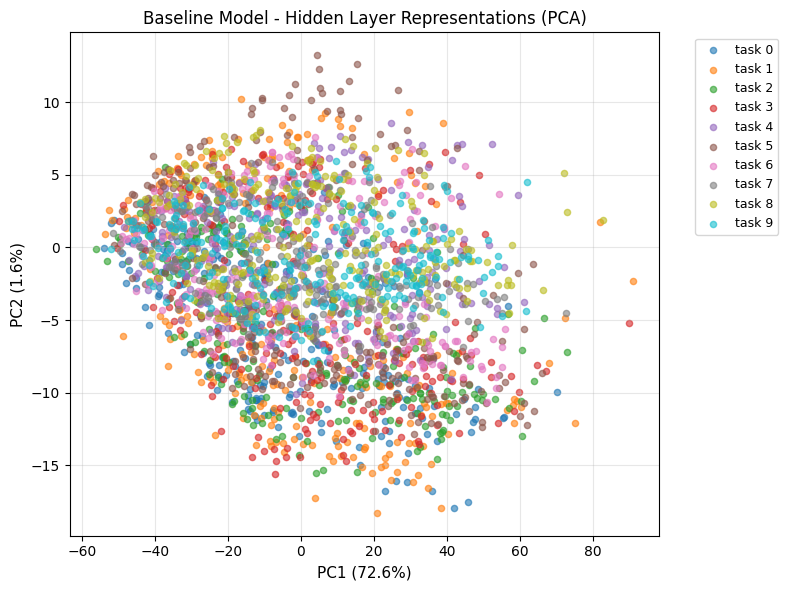

Explained variance: PC1=0.726, PC2=0.016


In [46]:
pca = PCA(n_components=2)
A_baseline_2d = pca.fit_transform(A_baseline)

plt.figure(figsize=(8, 6))
tab10_colors = plt.cm.tab10.colors  # 10 distinct colors
for t in range(min(num_tasks, 10)):  # Show up to 10 tasks to avoid color conflicts
    mask = (t_baseline == t)
    plt.scatter(A_baseline_2d[mask, 0], A_baseline_2d[mask, 1], 
               s=20, alpha=0.6, label=f"task {t}", color=tab10_colors[t])

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})", fontsize=11)
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})", fontsize=11)
plt.title(f"Baseline Model - Hidden Layer Representations (PCA)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")

## Step 7: Analyze Context-Aware Model Representation Space (PCA)

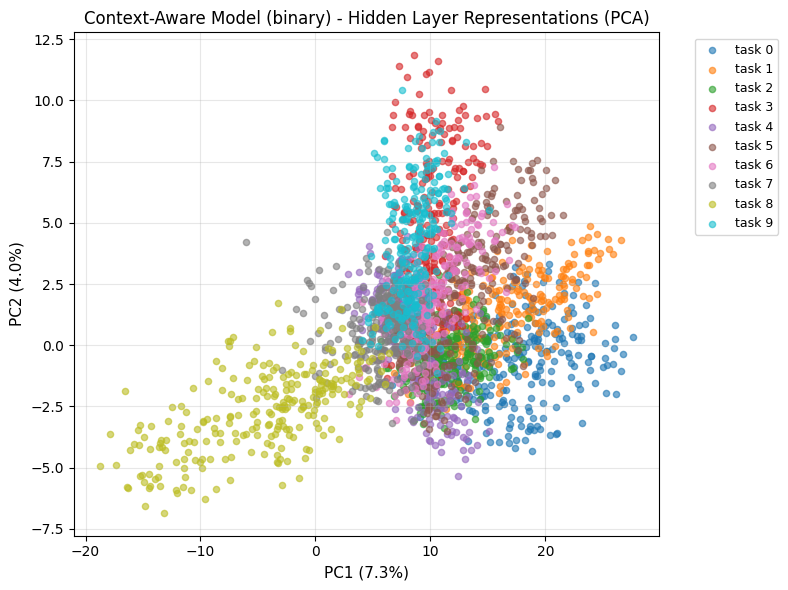

Explained variance: PC1=0.073, PC2=0.040


In [45]:
pca2 = PCA(n_components=2)
A_context_2d = pca2.fit_transform(A_context)

plt.figure(figsize=(8, 6))
tab10_colors = plt.cm.tab10.colors  # 10 distinct colors
for t in range(min(num_tasks, 10)):  # Show up to 10 tasks to avoid color conflicts
    mask = (t_context == t)
    plt.scatter(A_context_2d[mask, 0], A_context_2d[mask, 1], 
               s=20, alpha=0.6, label=f"task {t}", color=tab10_colors[t])

plt.xlabel(f"PC1 ({pca2.explained_variance_ratio_[0]:.1%})", fontsize=11)
plt.ylabel(f"PC2 ({pca2.explained_variance_ratio_[1]:.1%})", fontsize=11)
plt.title(f"Context-Aware Model ({context_type}) - Hidden Layer Representations (PCA)", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance: PC1={pca2.explained_variance_ratio_[0]:.3f}, PC2={pca2.explained_variance_ratio_[1]:.3f}")

## Summary

This notebook demonstrated:
1. **Dataset Agnostic**: Works with any torchvision dataset (MNIST, CIFAR-10, etc.)
2. **Task Flexibility**: Supports multiple task transform types (permutation, rotation, class-incremental)
3. **Model Comparison**: Compares baseline vs. context-aware models
4. **Analysis Tools**: Uses PCA to visualize how task representations evolve in hidden layers

### Key Observations:
- **Baseline Model**: May show task overlap/interference in latent space
- **Context-Aware Model**: Typically shows better task separation in latent space
- **Accuracy Curves**: Context-aware models often better maintain performance on task 0 as new tasks are learned

### Next Steps:
- Experiment with different datasets (e.g., `cifar10`, `fashionmnist`)
- Try different context types (`binary`, `complex`, `rotation`)
- Vary task transform types to study different continual learning scenarios
- Investigate the relationship between representation separability and task performance